In [1]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import seaborn as sns
from utils.mlflow_query import MlflowHelper
import numpy as np
from pathlib import Path
from src.features import knowledge
import json

Detecting 2 CUDA device(s).


In [2]:
mlflow_helper = MlflowHelper(pkl_file=None, 
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="831333387297563441",
    tracking_uri="http://localhost:5100")
mlflow_helper.query_runs()

Querying data per run...: 100%|██████████| 4736/4736 [02:23<00:00, 33.02it/s] 


In [3]:
def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic', 'causal_score'],
    save_fig = False,
    row_feature_name=None,
    hue_feature_name=None,
    col_feature_name=None,
    titles=None,
    palette=None,
    dodge=True,
    col_order=None,
    height=5,
    aspect=1 # width = height * aspect
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge, height=height, aspect=aspect
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        if save_fig:
            g.savefig("bar_{}.png".format(metric_name))

In [4]:
def count_attributes(df: pd.DataFrame, attr='data_tags_model_type'):
    return df.groupby([attr])[attr].count().sort_values(ascending=False)

In [5]:
def categorize_run_df(run_df, experimented_algos = ["causal_Fast-IAMB-jt", "causal_Fast-IAMB-smc-cor", "causal_MMPC-cor"]):
    bin_configs = { # label -> (bin_size, bin_overlap)
        'small-none': (['00:00:05'], ['00:00:00']),
        'medium-none': (['0:01:00','00:00:60'], ['00:00:00']),
        'large-none': (['00:10:00'], ['00:00:00']),
        'small-small': (['00:00:05'], ['00:00:01']),
        'medium-small': (['0:01:00','00:00:60'], ['00:00:12']),
        'large-small': (['00:10:00'], ['00:02:00']),
        'small-medium': (['00:00:05'], ['00:00:03']),
        'medium-medium': (['0:01:00','00:00:60'], ['00:00:30']),
        'large-medium': (['00:10:00'], ['00:05:00']),
        'small-large': (['00:00:05'], ['00:00:04']),
        'medium-large': (['0:01:00','00:00:60'], ['00:00:48', '00:00:50']),
        'large-large': (['00:10:00'], ['00:08:00']),
    }

    matrix_df = run_df.copy()
    for algo in experimented_algos:
        for label, config in bin_configs.items():
            bin_sizes, bin_overlap = config[0], config[1]
            matrix_df.loc[(matrix_df['data_params_TimeSeriesTransformerConfigbin_size'].isin(bin_sizes)) 
            & (matrix_df['data_params_TimeSeriesTransformerConfigbin_overlap'].isin(bin_overlap))
            & (matrix_df['data_tags_model_type'] == algo), 'data_tags_model_type'] = algo + '+' + label
    
    # Categorize by templates
    matrix_df.loc[matrix_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.77', 'data_tags_model_type'] = matrix_df.loc[
        matrix_df['data_params_HuaweiPreprocessorConfigfine_drain_log_st'] == '0.77', 'data_tags_model_type'
    ].apply(lambda x: x + "_more_templates")
    
    # Categorize by timestamps
    matrix_df.loc[matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 'data_tags_model_type'] = matrix_df.loc[
    matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False', 'data_tags_model_type'].apply(lambda x: x + '_with_ts')
    matrix_df.loc[matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True', 'data_tags_model_type'] = matrix_df.loc[
    matrix_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True', 'data_tags_model_type'].apply(lambda x: x + '_without_ts')

    return matrix_df

# Results - Performance

## Huawei

In [6]:
experimented_algos = ["causal_Fast-IAMB-jt", "causal_Fast-IAMB-smc-cor", "causal_MMPC-cor"]
huawei_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'huawei_logs')
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(experimented_algos + ['simple']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df["data_params_SequenceConfigtest_percentage"].fillna("").astype(str) == "0.1")
    & (mlflow_helper.run_df["data_params_ModelConfigbest_model_metric"] == "val_loss")
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_ModelConfigrnn_dim"] == "200")
    & (mlflow_helper.run_df["data_params_ModelConfigoptimizer"].fillna("adam") == "adam")
    & (mlflow_helper.run_df["data_params_ModelConfigdropout_rate"].fillna("0.0").astype(str) == "0.5")
    & (mlflow_helper.run_df["data_params_ModelConfigrnn_dropout"].fillna("0.0").astype(str) == "0.0")
    & (mlflow_helper.run_df["data_params_ModelConfigkernel_regularizer_scope"].fillna("[]") == "[]")
    & (mlflow_helper.run_df["data_params_ExperimentConfigbatch_size"].astype(str).fillna("") == "128")
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'].isin([np.nan, '0.05']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(['0.77', '0.75']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == "10")
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_df = categorize_run_df(huawei_df)

Querying metrics for runs: 100%|██████████| 505/505 [00:31<00:00, 16.14it/s]


In [7]:
count_attributes(huawei_df)

data_tags_model_type
causal_Fast-IAMB-jt+small-small_more_templates_without_ts    36
causal_Fast-IAMB-jt+large-medium_without_ts                  22
causal_Fast-IAMB-jt+small-medium_with_ts                     20
simple_with_ts                                               20
simple_more_templates_without_ts                             20
causal_MMPC-cor+large-small_without_ts                       20
causal_Fast-IAMB-smc-cor+small-small_with_ts                 20
causal_Fast-IAMB-jt+small-small_without_ts                   20
causal_Fast-IAMB-jt+large-medium_with_ts                     20
simple_without_ts                                            20
causal_Fast-IAMB-jt+medium-medium_with_ts                    20
causal_Fast-IAMB-smc-cor+small-small_without_ts              19
causal_Fast-IAMB-jt+medium-large_with_ts                     19
causal_Fast-IAMB-jt+large-small_with_ts                      18
causal_Fast-IAMB-jt+small-large_with_ts                      18
causal_Fast-IAMB-jt

In [8]:
pd.options.display.max_colwidth = 100
sorted_top_5_accuracy_median_df = pd.DataFrame(
    huawei_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best']
    .median()
    .sort_values(ascending=False)).reset_index()
sorted_top_5_accuracy_median_df

,data_tags_model_type,val_top_5_categorical_accuracy_history_best
0,causal_Fast-IAMB-jt+small-small_without_ts,0.833957
1,causal_Fast-IAMB-smc-cor+small-small_without_ts,0.833628
2,causal_Fast-IAMB-jt+small-none_without_ts,0.833443
3,causal_Fast-IAMB-smc-cor+medium-large_without_ts,0.833329
4,causal_Fast-IAMB-jt+large-medium_without_ts,0.833114
5,simple_without_ts,0.832964
6,causal_MMPC-cor+large-medium_without_ts,0.832886
7,causal_MMPC-cor+medium-large_without_ts,0.832772
8,causal_Fast-IAMB-jt+medium-medium_without_ts,0.832757
9,causal_MMPC-cor+medium-medium_without_ts,0.832586


In [9]:
# Sort by mean top 5 categorical accuracy
sorted_top_5_accuracy_mean_df = pd.DataFrame(
    huawei_df.groupby(['data_tags_model_type'])['val_top_5_categorical_accuracy_history_best']
    .mean()
    .sort_values(ascending=False)).reset_index()
sorted_top_5_accuracy_mean_df

,data_tags_model_type,val_top_5_categorical_accuracy_history_best
0,causal_Fast-IAMB-jt+small-small_without_ts,0.834112
1,causal_Fast-IAMB-smc-cor+small-small_without_ts,0.833637
2,causal_Fast-IAMB-jt+small-none_without_ts,0.833443
3,causal_Fast-IAMB-smc-cor+medium-large_without_ts,0.833210
4,causal_MMPC-cor+medium-large_without_ts,0.832930
5,causal_Fast-IAMB-jt+large-medium_without_ts,0.832924
6,simple_without_ts,0.832727
7,causal_MMPC-cor+large-medium_without_ts,0.832672
8,causal_MMPC-cor+small-large_without_ts,0.832666
9,causal_Fast-IAMB-jt+medium-medium_without_ts,0.832652


In [10]:
k = 3
# Without timestamps
top_k_mean_no_ts = sorted_top_5_accuracy_mean_df['data_tags_model_type'].tolist()[:k]
top_k_median_no_ts = sorted_top_5_accuracy_median_df['data_tags_model_type'].tolist()[:k]

if "simple_without_ts" not in top_k_mean_no_ts:
    top_k_mean_no_ts.append('simple_without_ts')

if "simple_without_ts" not in top_k_median_no_ts:
    top_k_median_no_ts.append('simple_without_ts')

# With timestamps
top_k_mean_ts = list(filter(lambda x: x.endswith('with_ts'),sorted_top_5_accuracy_mean_df['data_tags_model_type'].tolist()))[:k]
top_k_median_ts = list(filter(lambda x: x.endswith('with_ts'),sorted_top_5_accuracy_median_df['data_tags_model_type'].tolist()))[:k]

if "simple_with_ts" not in top_k_mean_ts:
    top_k_mean_ts.append('simple_with_ts')

if "simple_with_ts" not in top_k_median_ts:
    top_k_median_ts.append('simple_with_ts')

### With Timestamps

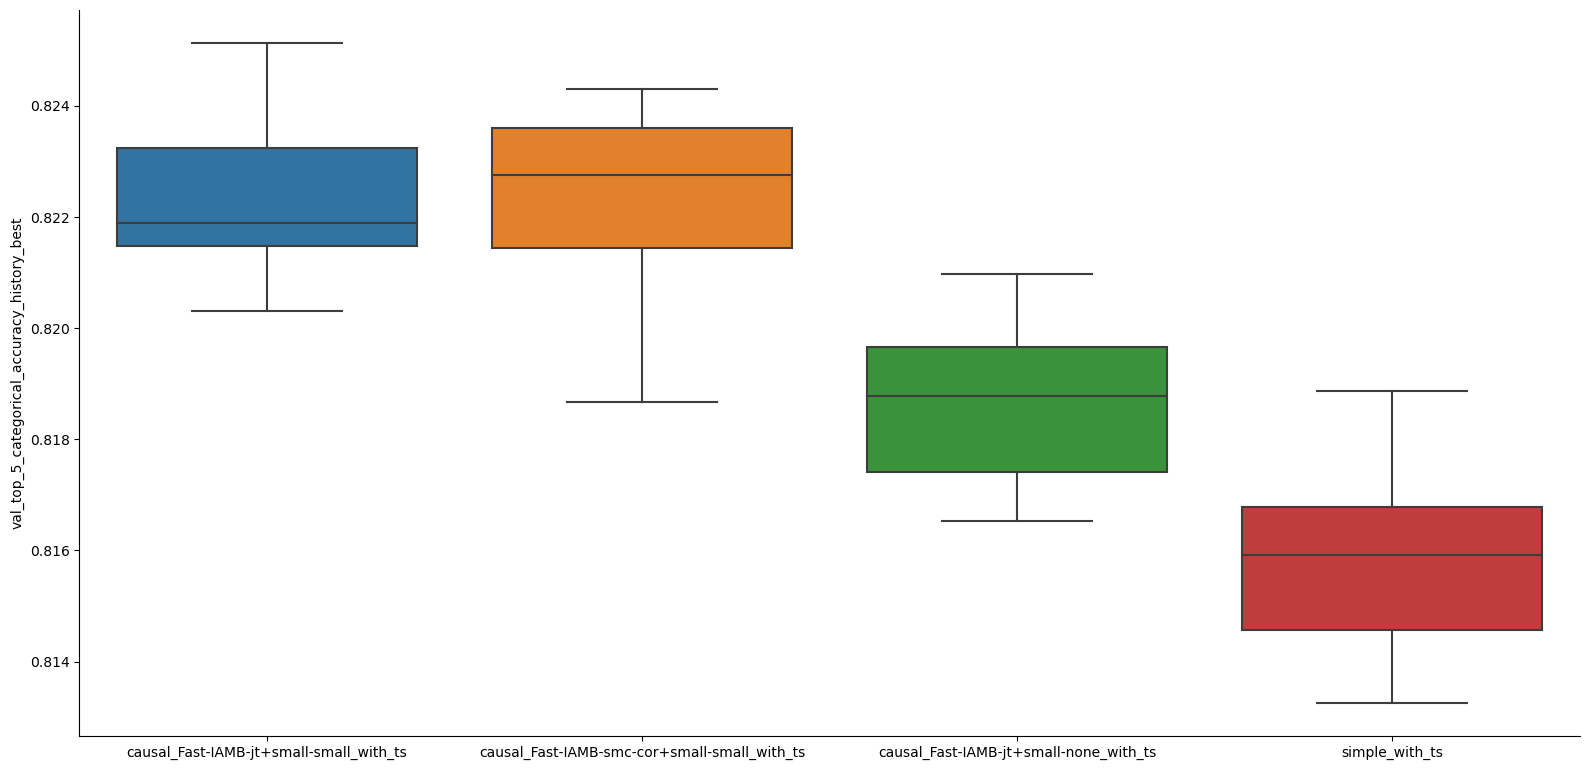

In [11]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_mean_ts,
height=8,
aspect=2)

### Without Timestamps

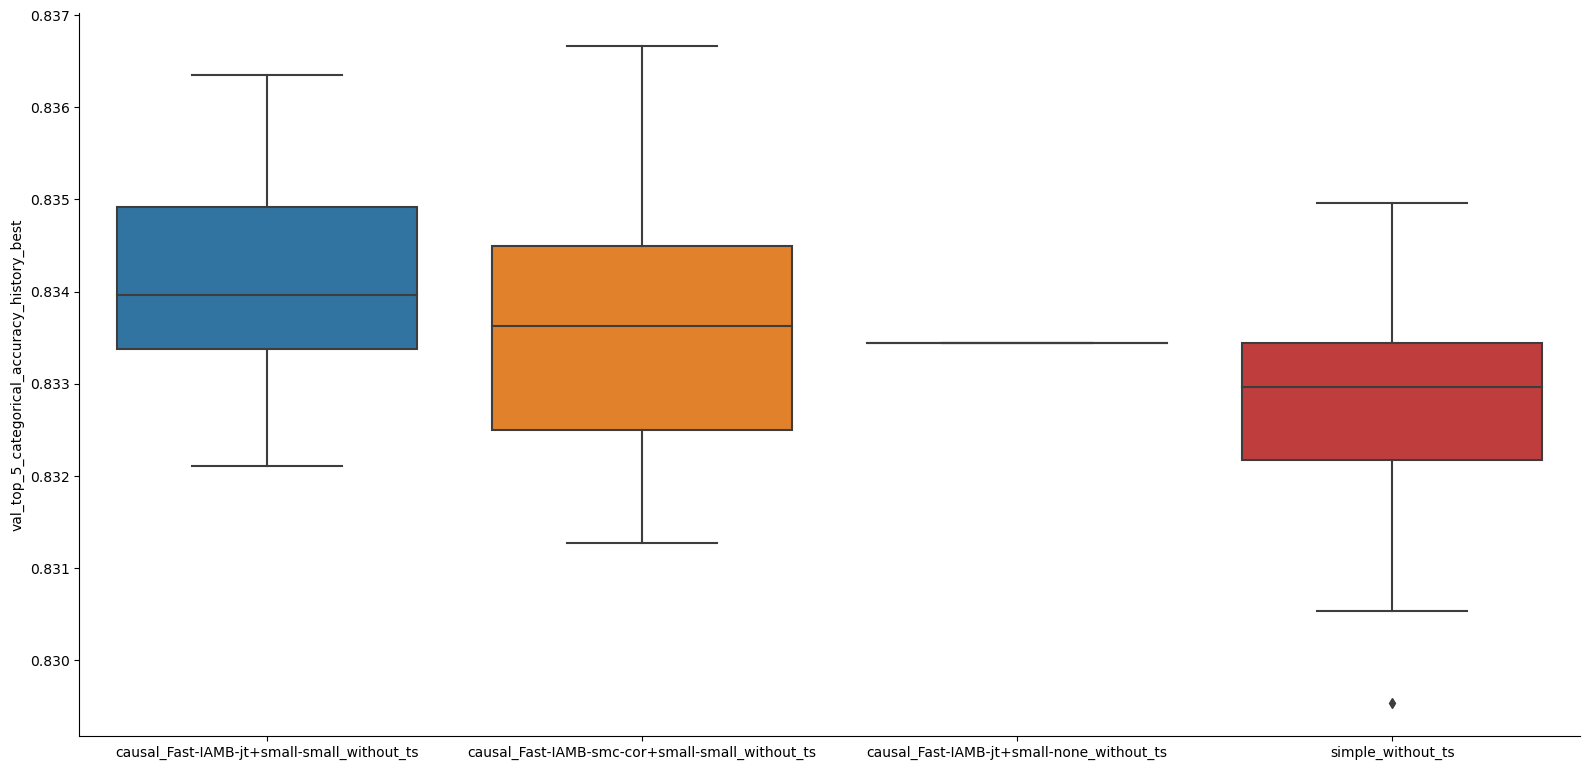

In [12]:
plot_best_metric_bar(huawei_df, ['val_top_5_categorical_accuracy_history_best'],
x_order = top_k_mean_no_ts,
height=8,
aspect=2)

## BGL

In [13]:
bgl_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == "bgl_logs")
    & (mlflow_helper.run_df['data_params_BGLPreprocessorConfigaggregated_log_file'] == 'data/BGL_2k.csv')
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
bgl_df = mlflow_helper.load_best_metrics_for_ids(set(bgl_df['info_run_id']))

Querying metrics for runs: 100%|██████████| 100/100 [00:06<00:00, 16.60it/s]


In [14]:
count_attributes(bgl_df)

data_tags_model_type
causal_Fast-IAMB-jt    20
causal_heuristic       20
hierarchy              20
simple                 20
text                   20
Name: data_tags_model_type, dtype: int64

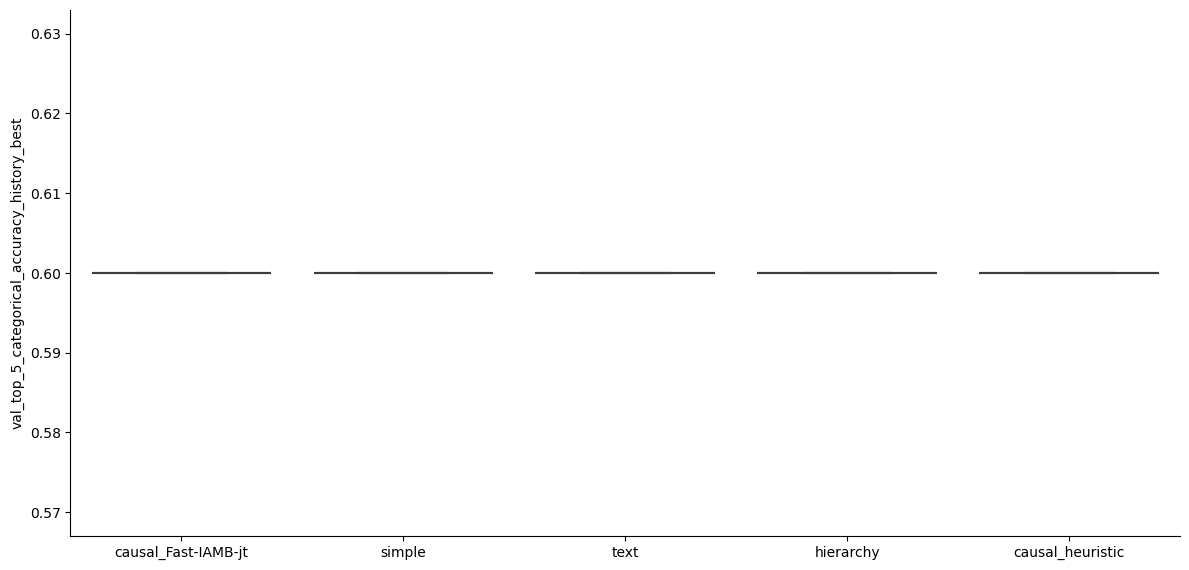

In [15]:
model_types = list(set(bgl_df['data_tags_model_type']))
plot_best_metric_bar(bgl_df, ['val_top_5_categorical_accuracy_history_best'], x_order=model_types, height=6, aspect=2)

## HDFS

In [16]:
hdfs_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == "hdfs_logs")
    & (mlflow_helper.run_df['data_params_HDFSPreprocessorConfigaggregated_log_file'] == 'data/HDFS_2k.csv')
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
hdfs_df = mlflow_helper.load_best_metrics_for_ids(set(hdfs_df['info_run_id']))

Querying metrics for runs: 100%|██████████| 100/100 [00:06<00:00, 16.56it/s]


In [17]:
count_attributes(hdfs_df)

data_tags_model_type
causal_Fast-IAMB-jt    20
causal_heuristic       20
hierarchy              20
simple                 20
text                   20
Name: data_tags_model_type, dtype: int64

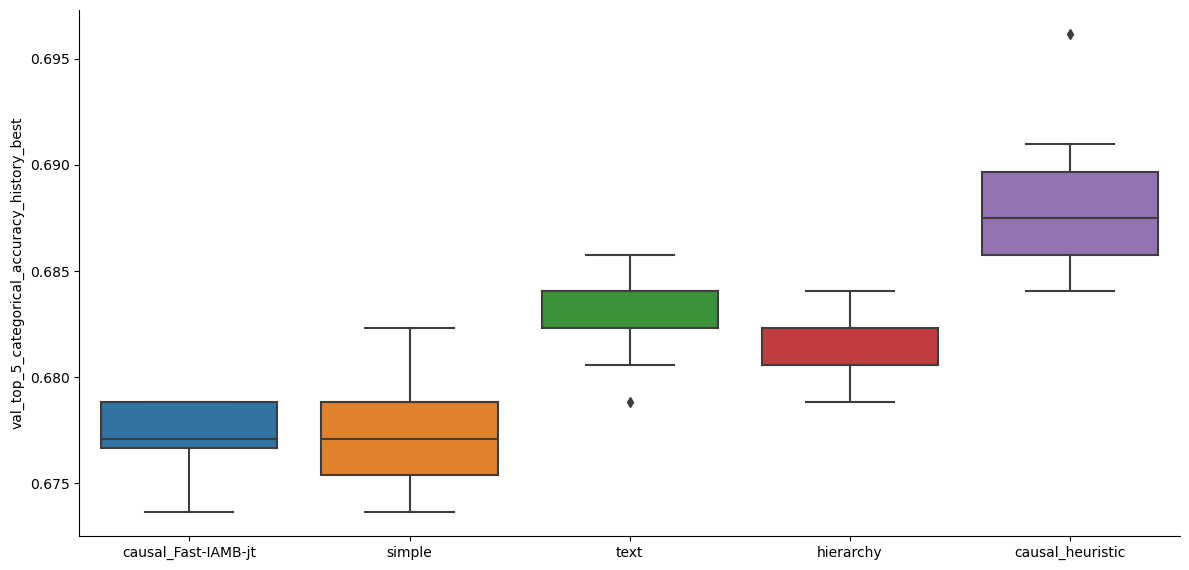

In [18]:
model_types = list(set(hdfs_df['data_tags_model_type']))
plot_best_metric_bar(hdfs_df, ['val_top_5_categorical_accuracy_history_best'], x_order=model_types, height=6, aspect=2)

# Results - Scatter Plots

In [19]:
def read_knowledge_dataframes(knowledge_type):
    knowledge_path = Path(f'/home/i40/almasrirz/Domain-Guided-Monitoring/data/knowledge_{knowledge_type}')
    pathlist = knowledge_path.glob('**/*.csv')
    dataframes = {}
    for path in pathlist:
        knowledge_name = path.name.split('_knowledge')[0]
        dataframes[knowledge_name] = pd.read_csv(path)
    return dataframes

In [20]:
def fetch_statistics(knowledge_type):
    statistics_records = []
    dataframes = read_knowledge_dataframes(knowledge_type)
    for name, df in dataframes.items():
        k = None
        metadata = f'/home/i40/almasrirz/Domain-Guided-Monitoring/data/knowledge_{knowledge_type}/x_vocab'
        if 'with_ts' in name:
            metadata += '_with_ts'
        if 'without_ts' in name:
            metadata += '_without_ts'
        if 'more_templates' in name:
            metadata += '_more_templates'
           
        with open(metadata + '.json', 'r') as file:
            metadata = json.load(file)

        if name.startswith('causal'):
            k = knowledge.CausalityKnowledge(knowledge.KnowledgeConfig())
            k.build_causality_from_df(df, metadata)
        elif name.startswith('hierarchy'):
            k = knowledge.HierarchyKnowledge(knowledge.KnowledgeConfig())
            k.build_hierarchy_from_df(df, metadata)
        else:
            k = knowledge.DescriptionKnowledge(knowledge.KnowledgeConfig())
            k.build_knowledge_from_df(df, metadata)
        v_in = len(k.vocab)
        v_g = len(k.extended_vocab)
        v_hidden = v_g - v_in
        edges = set()
        for i in range(len(k.vocab)):
            connections = k.get_connections_for_idx(i)
            for connection in connections:
                edges.add((i, connection))
        statistics_records.append({
            'Model': name,
            'V_G': v_g,
            'V_in': v_in,
            'V_hidden': v_hidden,
            'E_G': len(edges)
        })
    return pd.DataFrame.from_records(statistics_records)

## BGL

In [55]:
bgl_stats_df = fetch_statistics('bgl')
bgl_stats_df = bgl_stats_df[~(bgl_stats_df['Model'].str.endswith('label'))]
bgl_stats_df

Building Hierarchy from df: 19705it [00:00, 41475.16it/s]
Building Causality from df: 55564it [00:01, 43075.81it/s]
Building Causality from df: 8238it [00:00, 43350.27it/s]
Preprocessing description words: 100%|██████████| 4728/4728 [00:00<00:00, 41353.78it/s]
Building Causality from df: 28021it [00:00, 39634.24it/s]
Building Causality from df: 750it [00:00, 43469.70it/s]
Building Hierarchy from df: 7153it [00:00, 39388.54it/s]
Building Causality from df: 82it [00:00, 41693.89it/s]
Preprocessing description words: 100%|██████████| 2007/2007 [00:00<00:00, 41757.45it/s]


,Model,V_G,V_in,V_hidden,E_G
4,causal_heuristic,2007,1,2006,2007
6,hierarchy,5150,1,5149,5150
7,causal_Fast-IAMB-jt,2,1,1,2
8,text,4,1,3,4


In [62]:
bgl_sp_df = pd.merge(bgl_df, bgl_stats_df, how='left', left_on='data_tags_model_type', right_on='Model')
set(bgl_sp_df['data_tags_model_type'])

{'causal_Fast-IAMB-jt', 'causal_heuristic', 'hierarchy', 'simple', 'text'}

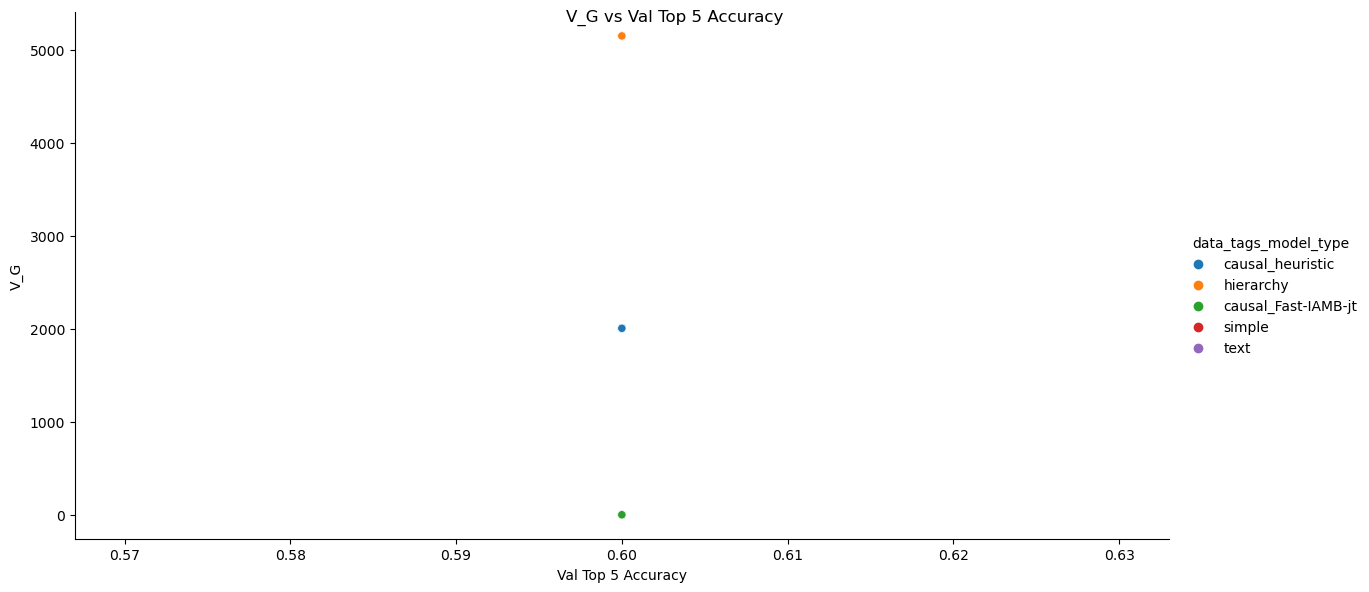

In [59]:
g = sns.relplot(data=bgl_sp_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

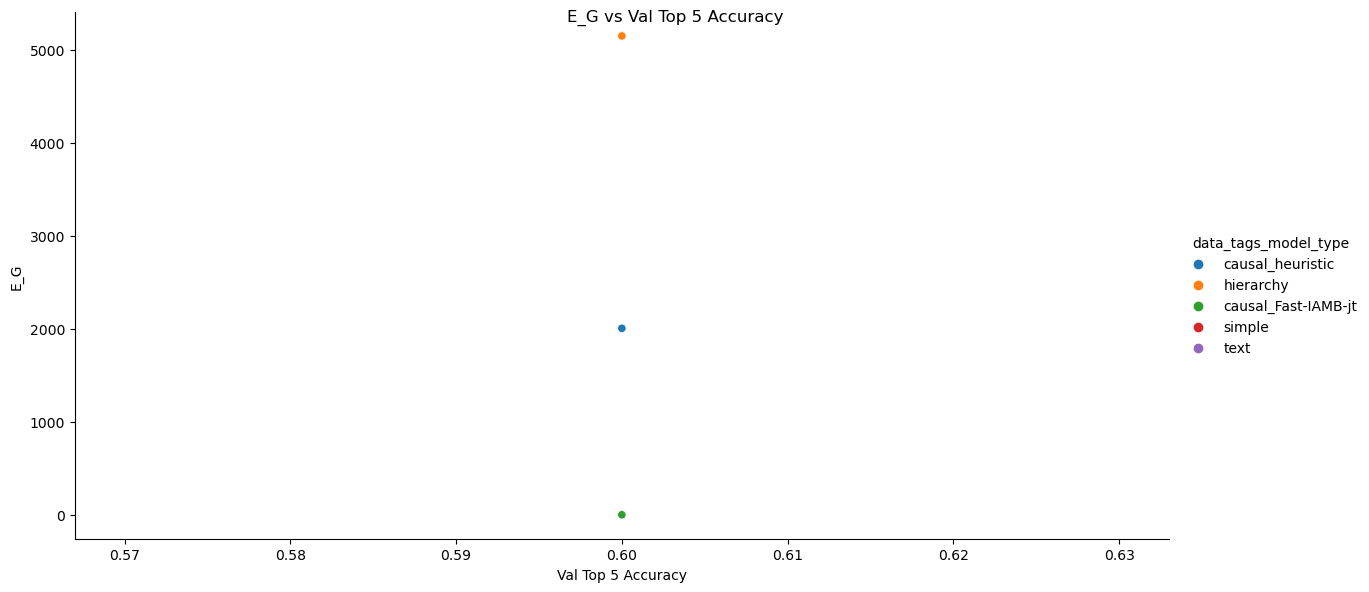

In [60]:
g = sns.relplot(data=bgl_sp_df, x='val_top_5_categorical_accuracy_history_best', y='E_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('E_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

## HDFS

In [63]:
hdfs_stats_df = fetch_statistics('hdfs')
hdfs_stats_df

Building Causality from df: 9524it [00:00, 40002.68it/s]
Building Hierarchy from df: 2050it [00:00, 39153.05it/s]
Building Causality from df: 36it [00:00, 37477.03it/s]
Preprocessing description words: 100%|██████████| 673/673 [00:00<00:00, 37414.89it/s]


,Model,V_G,V_in,V_hidden,E_G
0,causal_heuristic,673,166,507,3073
1,hierarchy,675,166,509,2704
2,causal_Fast-IAMB-jt,170,166,4,172
3,text,507,166,341,864


In [64]:
hdfs_sp_df = pd.merge(hdfs_df, hdfs_stats_df, how='left', left_on='data_tags_model_type', right_on='Model')
set(hdfs_sp_df['data_tags_model_type'])

{'causal_Fast-IAMB-jt', 'causal_heuristic', 'hierarchy', 'simple', 'text'}

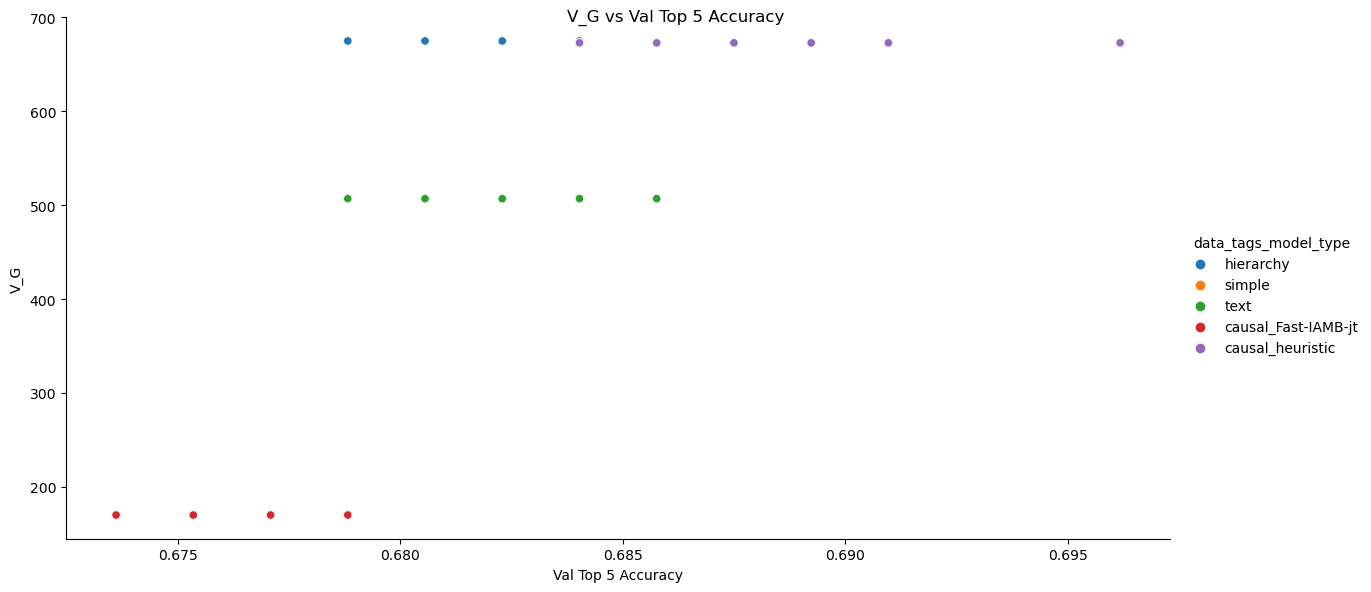

In [65]:
g = sns.relplot(data=hdfs_sp_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

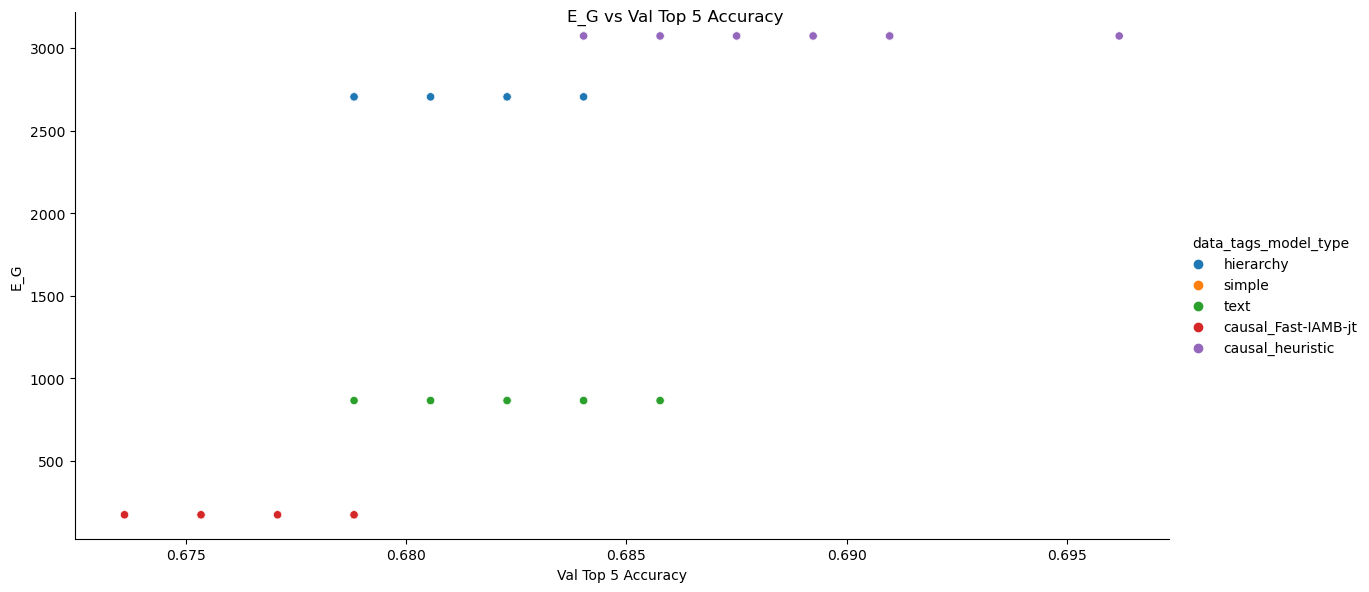

In [66]:
g = sns.relplot(data=hdfs_sp_df, x='val_top_5_categorical_accuracy_history_best', y='E_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('E_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

## Huawei

In [21]:
knowledge_types_with_ts = ['simple_with_ts',
                           'causal_heuristic_with_ts',
                           'text_with_ts',
                           'hierarchy_with_ts',
                           'causal_Fast-IAMB-jt_with_ts_small_small',
                           'causal_Fast-IAMB-jt_with_ts_more_templates_small_small']
knowledge_types_without_ts = ['simple_without_ts',
                           'causal_heuristic_without_ts',
                           'text_without_ts',
                           'text_without_ts_more_templates',
                           'hierarchy_without_ts',
                           'hierarchy_without_ts_more_templates',
                           'causal_Fast-IAMB-jt_without_ts_small_small',
                           'causal_Fast-IAMB-jt_without_ts_more_templates_small_small']

In [22]:
experimented_algos = ["causal_Fast-IAMB-jt", "simple", "hierarchy", "text", "causal_heuristic"]
huawei_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'huawei_logs')
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(experimented_algos))
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigmin_causality'] == '0.01')
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'].isin([np.nan, '0.05']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(['0.77', '0.75']))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == "10")
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_df = categorize_run_df(huawei_df)

Querying metrics for runs: 100%|██████████| 451/451 [00:28<00:00, 16.10it/s]


In [ ]:
huawei_stats_df = fetch_statistics('huawei')

In [24]:
huawei_stats_with_ts_df = huawei_stats_df[huawei_stats_df['Model'].isin(knowledge_types_with_ts)]
huawei_stats_with_ts_df

,Model,V_G,V_in,V_hidden,E_G
2,causal_Fast-IAMB-jt_with_ts_more_templates_small_small,4105,3905,200,5646
7,hierarchy_with_ts,1968,1446,522,24817
35,causal_heuristic_with_ts,2104,1446,658,35835
58,causal_Fast-IAMB-jt_with_ts_small_small,1653,1446,207,2166


In [25]:
huawei_stats_without_ts_df = huawei_stats_df[huawei_stats_df['Model'].isin(knowledge_types_without_ts)]
huawei_stats_without_ts_df

,Model,V_G,V_in,V_hidden,E_G
9,text_without_ts_more_templates,7260,3062,4198,30157
14,causal_heuristic_without_ts,1559,865,694,19591
21,causal_Fast-IAMB-jt_without_ts_small_small,1091,865,226,1132
22,text_without_ts,3716,865,2851,17778
34,hierarchy_without_ts,1387,865,522,15335
42,hierarchy_without_ts_more_templates,3580,3062,518,51434
51,causal_Fast-IAMB-jt_without_ts_more_templates_small_small,3288,3062,226,4531


In [26]:
huawei_stats_filtered_df = pd.concat([huawei_stats_with_ts_df, huawei_stats_without_ts_df]).reset_index(drop=True)
huawei_stats_filtered_df

,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt_with_ts_more_templates_small_small,4105,3905,200,5646
1,hierarchy_with_ts,1968,1446,522,24817
2,causal_heuristic_with_ts,2104,1446,658,35835
3,causal_Fast-IAMB-jt_with_ts_small_small,1653,1446,207,2166
4,text_without_ts_more_templates,7260,3062,4198,30157
5,causal_heuristic_without_ts,1559,865,694,19591
6,causal_Fast-IAMB-jt_without_ts_small_small,1091,865,226,1132
7,text_without_ts,3716,865,2851,17778
8,hierarchy_without_ts,1387,865,522,15335
9,hierarchy_without_ts_more_templates,3580,3062,518,51434


In [27]:
# Need to replace the causal_Fast-IAMB-jt column name to match the huawei_df
huawei_stats_filtered_df.replace({
    'causal_Fast-IAMB-jt_with_ts_more_templates_small_small': 'causal_Fast-IAMB-jt+small-small_more_templates_with_ts',
    'causal_Fast-IAMB-jt_without_ts_more_templates_small_small': 'causal_Fast-IAMB-jt+small-small_more_templates_without_ts',
    'causal_Fast-IAMB-jt_with_ts_small_small': 'causal_Fast-IAMB-jt+small_small_with_ts',
    'causal_Fast-IAMB-jt_without_ts_small_small': 'causal_Fast-IAMB-jt+small-small_without_ts',
    'causal_Fast-IAMB-jt_with_ts_small_small': 'causal_Fast-IAMB-jt+small-small_with_ts',
    'hierarchy_without_ts_more_templates': 'hierarchy_more_templates_without_ts',
    'text_without_ts_more_templates': 'text_more_templates_without_ts',
    }, inplace=True)
huawei_stats_filtered_df

,Model,V_G,V_in,V_hidden,E_G
0,causal_Fast-IAMB-jt+small-small_more_templates_with_ts,4105,3905,200,5646
1,hierarchy_with_ts,1968,1446,522,24817
2,causal_heuristic_with_ts,2104,1446,658,35835
3,causal_Fast-IAMB-jt+small-small_with_ts,1653,1446,207,2166
4,text_more_templates_without_ts,7260,3062,4198,30157
5,causal_heuristic_without_ts,1559,865,694,19591
6,causal_Fast-IAMB-jt+small-small_without_ts,1091,865,226,1132
7,text_without_ts,3716,865,2851,17778
8,hierarchy_without_ts,1387,865,522,15335
9,hierarchy_more_templates_without_ts,3580,3062,518,51434


In [28]:
count_attributes(huawei_df)

data_tags_model_type
causal_Fast-IAMB-jt+small-small_more_templates_without_ts    36
hierarchy_without_ts                                         28
causal_Fast-IAMB-jt+large-medium_without_ts                  22
text_without_ts                                              21
text_more_templates_without_ts                               21
causal_Fast-IAMB-jt+small-small_without_ts                   20
causal_Fast-IAMB-jt+medium-medium_with_ts                    20
simple_more_templates_without_ts                             20
causal_Fast-IAMB-jt+small-medium_with_ts                     20
causal_Fast-IAMB-jt+large-medium_with_ts                     20
causal_heuristic_with_ts                                     20
causal_Fast-IAMB-jt+medium-large_with_ts                     19
causal_Fast-IAMB-jt+large-small_with_ts                      18
causal_Fast-IAMB-jt+small-large_with_ts                      18
causal_Fast-IAMB-jt+medium-none_with_ts                      17
causal_Fast-IAMB-jt

In [29]:
huawei_filtered_df = huawei_df[huawei_df['data_tags_model_type'].isin(huawei_stats_filtered_df['Model'].tolist())]
count_attributes(huawei_filtered_df)

data_tags_model_type
causal_Fast-IAMB-jt+small-small_more_templates_without_ts    36
hierarchy_without_ts                                         28
text_more_templates_without_ts                               21
text_without_ts                                              21
causal_Fast-IAMB-jt+small-small_without_ts                   20
causal_heuristic_with_ts                                     20
causal_Fast-IAMB-jt+small-small_with_ts                      15
hierarchy_more_templates_without_ts                          14
hierarchy_with_ts                                             9
causal_heuristic_without_ts                                   4
causal_Fast-IAMB-jt+small-small_more_templates_with_ts        3
Name: data_tags_model_type, dtype: int64

In [30]:
huawei_merged_df = pd.merge(huawei_filtered_df, huawei_stats_filtered_df, how='left', left_on=['data_tags_model_type'], right_on=['Model'])

In [31]:
count_attributes(huawei_filtered_df)

data_tags_model_type
causal_Fast-IAMB-jt+small-small_more_templates_without_ts    36
hierarchy_without_ts                                         28
text_more_templates_without_ts                               21
text_without_ts                                              21
causal_Fast-IAMB-jt+small-small_without_ts                   20
causal_heuristic_with_ts                                     20
causal_Fast-IAMB-jt+small-small_with_ts                      15
hierarchy_more_templates_without_ts                          14
hierarchy_with_ts                                             9
causal_heuristic_without_ts                                   4
causal_Fast-IAMB-jt+small-small_more_templates_with_ts        3
Name: data_tags_model_type, dtype: int64

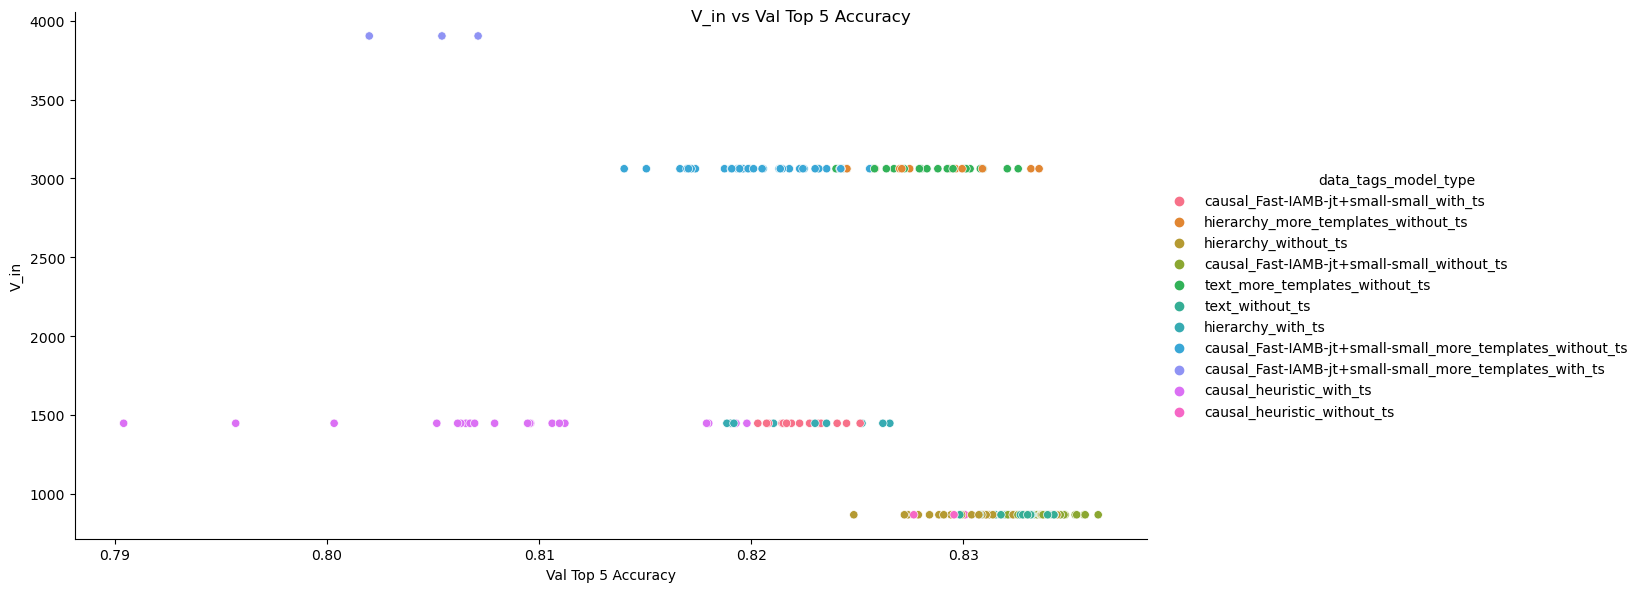

In [32]:
g = sns.relplot(data=huawei_merged_df, x='val_top_5_categorical_accuracy_history_best', y='V_in', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

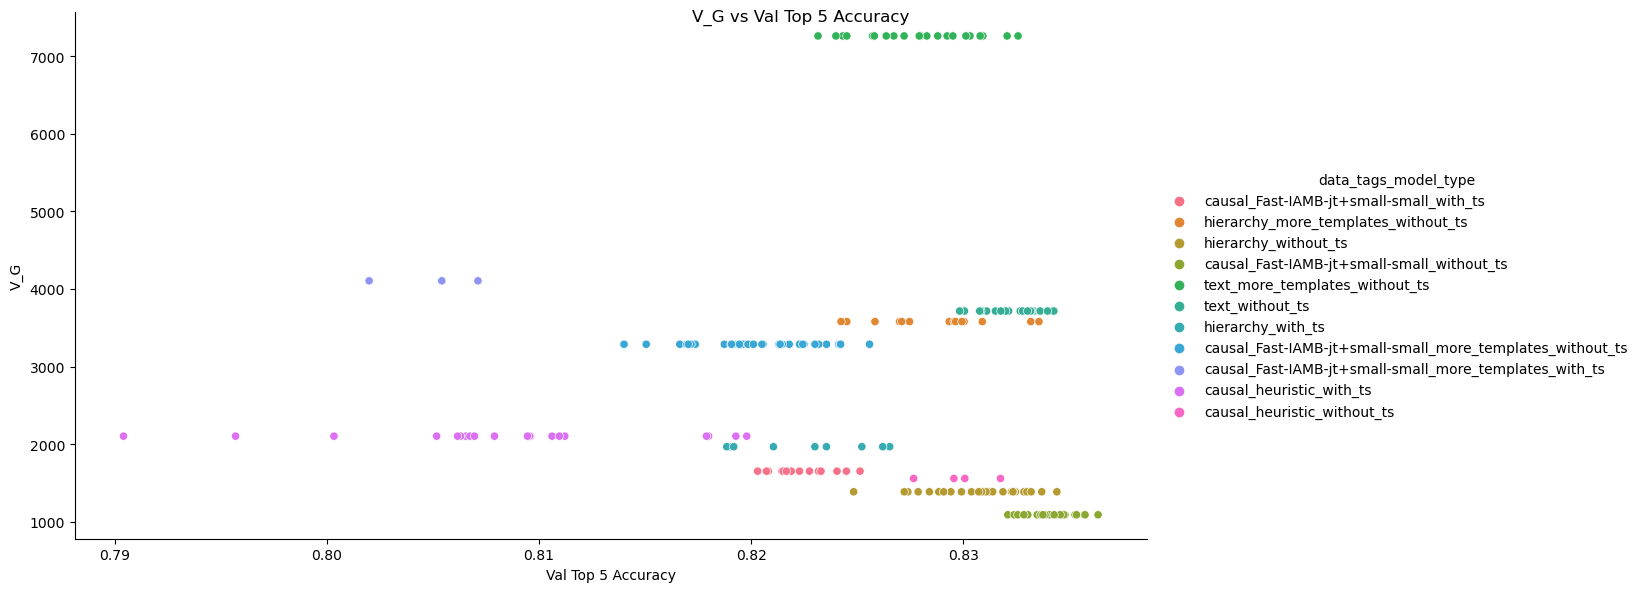

In [33]:
g = sns.relplot(data=huawei_merged_df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

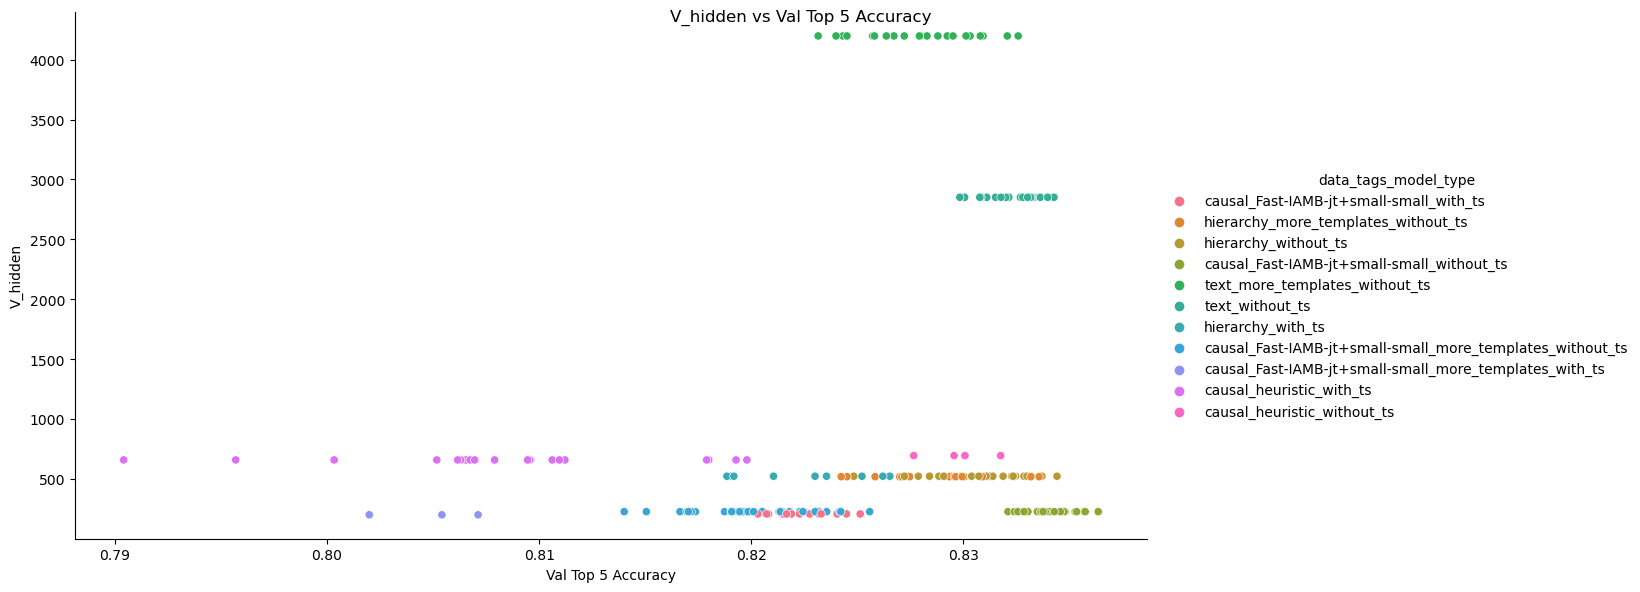

In [34]:
g = sns.relplot(data=huawei_merged_df, x='val_top_5_categorical_accuracy_history_best', y='V_hidden', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_hidden vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

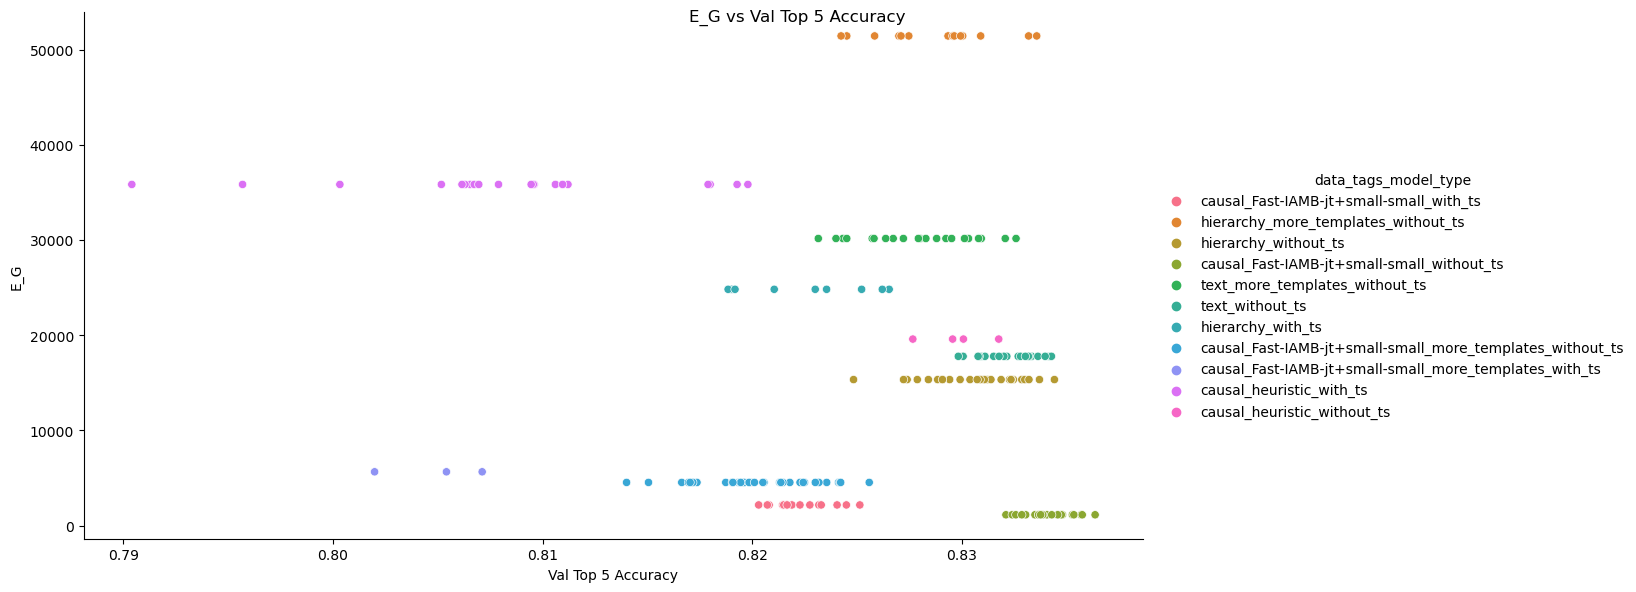

In [35]:
g = sns.relplot(data=huawei_merged_df, x='val_top_5_categorical_accuracy_history_best', y='E_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('E_G vs Val Top 5 Accuracy')
g.set_xlabels('Val Top 5 Accuracy')
g

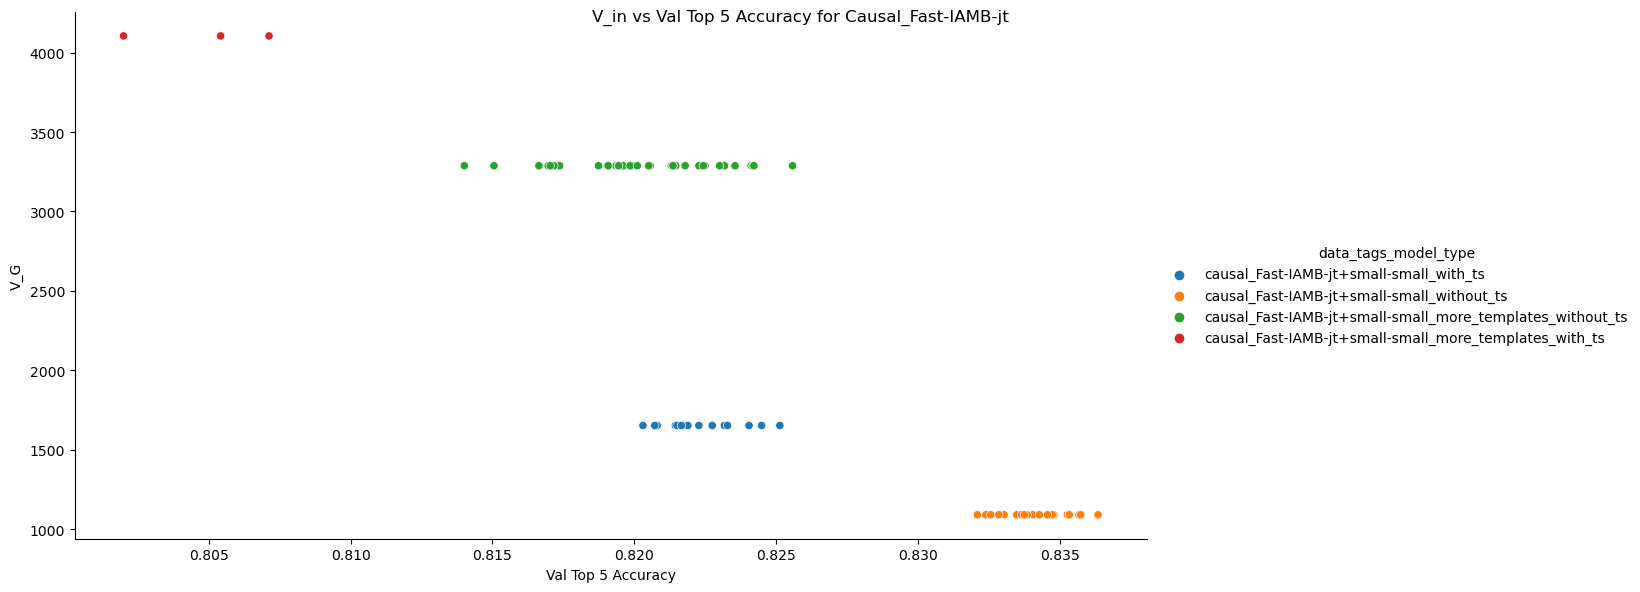

In [39]:
df = huawei_merged_df[huawei_merged_df['data_tags_model_type'].str.startswith('causal_Fast-IAMB-jt')]
g = sns.relplot(data=df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy for Causal_Fast-IAMB-jt')
g.set_xlabels('Val Top 5 Accuracy')
g

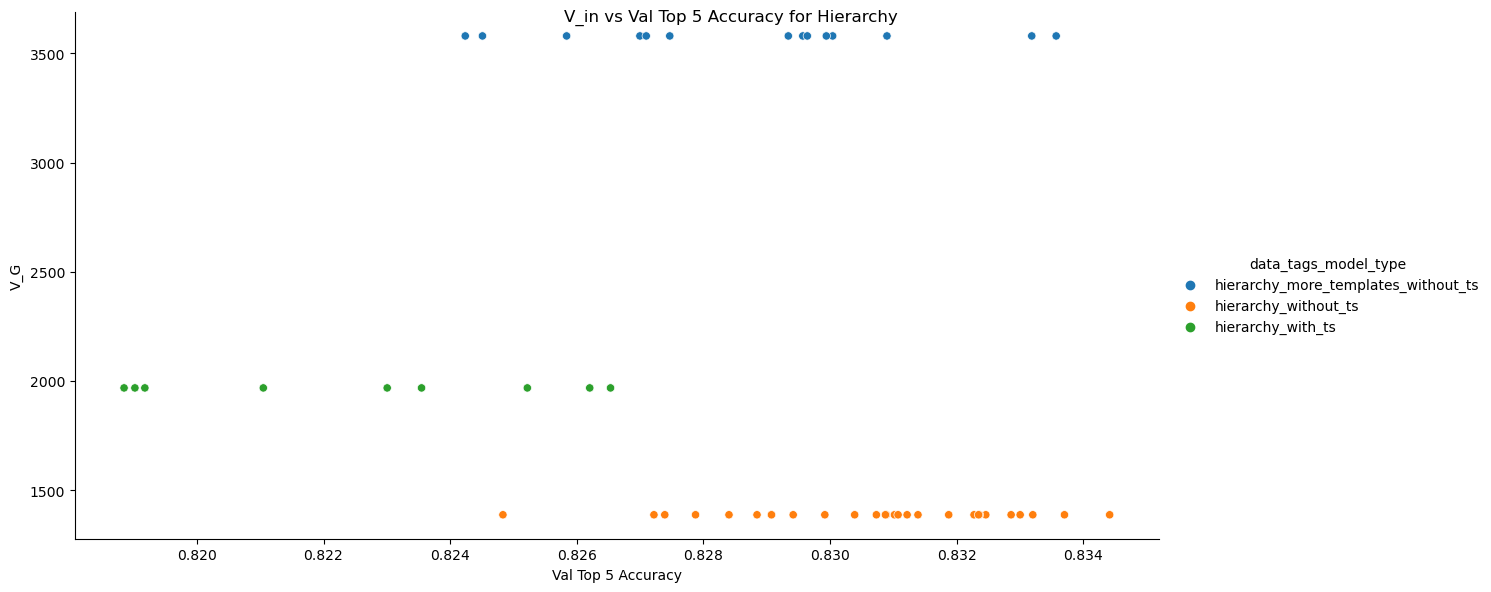

In [40]:
df = huawei_merged_df[huawei_merged_df['data_tags_model_type'].str.startswith('hierarchy')]
g = sns.relplot(data=df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy for Hierarchy')
g.set_xlabels('Val Top 5 Accuracy')
g

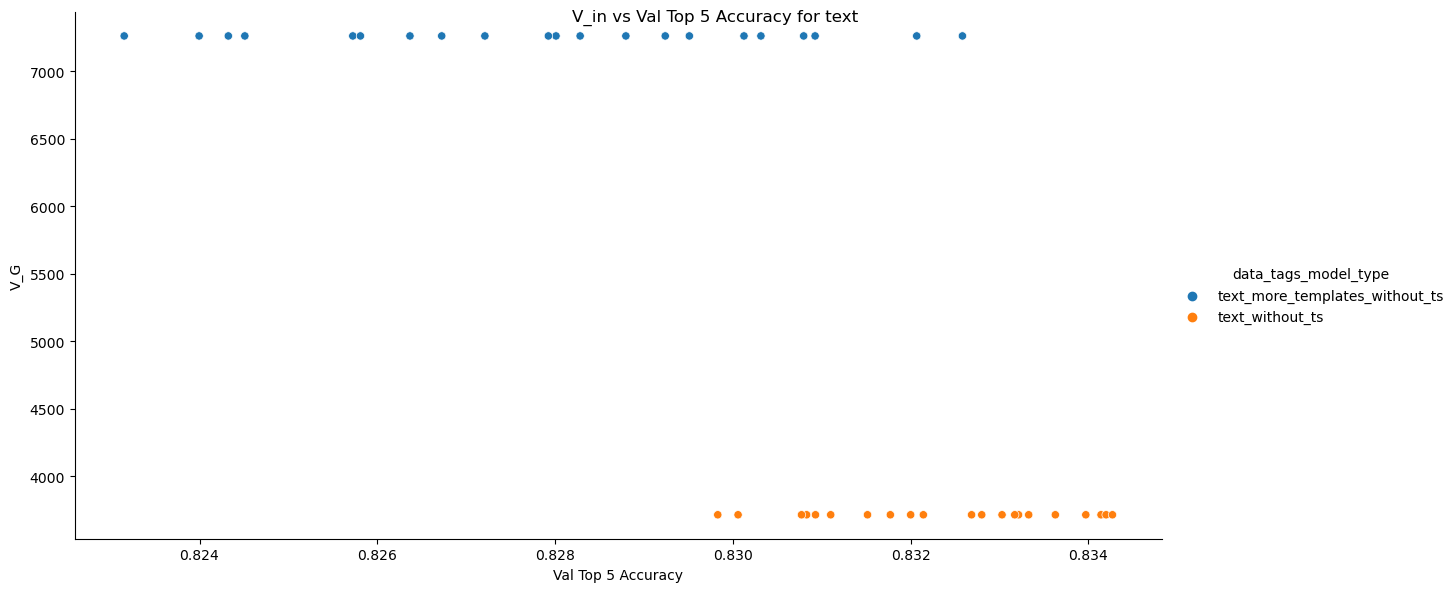

In [41]:
df = huawei_merged_df[huawei_merged_df['data_tags_model_type'].str.startswith('text')]
g = sns.relplot(data=df, x='val_top_5_categorical_accuracy_history_best', y='V_G', hue='data_tags_model_type', height=6, aspect=2)
g.fig.suptitle('V_in vs Val Top 5 Accuracy for text')
g.set_xlabels('Val Top 5 Accuracy')
g